In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgboost
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import minimize


In [2]:
#1. Data Loading
# Load the datasets
train_data = pd.read_csv('aapl_5m_train.csv')
validation_data = pd.read_csv('aapl_5m_validation.csv')


#2. Feature Engineering
# Calculate moving averages
train_data['MA5'] = train_data['Close'].rolling(window=5).mean()
train_data['MA10'] = train_data['Close'].rolling(window=10).mean()

# Define target variable: 1 if the next close is higher than the current close, else 0
train_data['Target'] = (train_data['Close'].shift(-1) > train_data['Close']).astype(int)

# Drop NA values
train_data.dropna(inplace=True)

# Define independent variables and target variable
X = train_data[['MA5', 'MA10']]
Y = train_data['Target']

In [3]:
#3. Modeling
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X, Y)
y_hat = log_reg.predict(X)

# SVC
svc = SVC()
svc.fit(X, Y)

# XGBoost
boosted_model = xgboost.XGBClassifier()
boosted_model.fit(X, Y)
y_hat_boost = boosted_model.predict(X)

print(confusion_matrix(Y, y_hat_boost))
print(confusion_matrix(Y, y_hat))
print(accuracy_score(Y, y_hat_boost))

[[6084 3765]
 [4031 5643]]
[[9849    0]
 [9674    0]]
0.6006761255954515


In [4]:
#4. Optimization
def optimize_params(x: np.array) -> float:
    gamma, reg_alpha = x  # Unpack parameters
    n_estimators = 1
    model_ = xgboost.XGBClassifier(n_estimators=n_estimators,
                                   gamma=gamma,
                                   reg_alpha=reg_alpha,
                                   reg_lambda=reg_alpha)
    model_.fit(X, Y)
    y_pred = model_.predict(X)
    acc = accuracy_score(Y, y_pred)
    return -acc

bnds = ((0, 10), (1e-4, 10))
x0 = [0, 1e-3]
res = minimize(optimize_params, bounds=bnds, x0=x0, method="Nelder-Mead", tol=1e-10)
print(res)
print(res.x)

opt_model = xgboost.XGBClassifier(n_estimators=10,
                                  gamma=res.x[0],
                                  reg_alpha=res.x[1],
                                  reg_lambda=res.x[1])
opt_model.fit(X, Y)
print(confusion_matrix(Y, opt_model.predict(X)))


 final_simplex: (array([[0.00000000e+00, 1.00000000e-03],
       [5.96046448e-11, 1.00000000e-03],
       [0.00000000e+00, 1.00000001e-03]]), array([-0.51805563, -0.51805563, -0.51805563]))
           fun: -0.5180556266967167
       message: 'Optimization terminated successfully.'
          nfev: 91
           nit: 23
        status: 0
       success: True
             x: array([0.   , 0.001])
[0.    0.001]
[[5252 4597]
 [4254 5420]]


In [5]:
#5. Combination of Models
def combine_predictions(preds):
    """Combine predictions using majority voting."""
    combined = sum(preds)
    # If 2 or more models predict 1, return 1. Otherwise, return 0.
    return 1 if combined >= 2 else 0

# Predictions from each model
y_hat_lr = log_reg.predict(X)
y_hat_svc = svc.predict(X)
y_hat_xgb = opt_model.predict(X)

# Combine predictions
combined_predictions = [combine_predictions([y_hat_lr[i], y_hat_svc[i], y_hat_xgb[i]]) for i in range(len(y_hat_lr))]


In [9]:
#6. Backtesting
initial_cash = 1000000  # Starting cash
cash = initial_cash
stock = 0
portfolio_values = []

for i in range(len(train_data) - 1):
    # Buy signal
    if combined_predictions[i] == 1 and cash >= train_data['Close'].iloc[i]:
        stock += 1
        cash -= train_data['Close'].iloc[i]
    # Sell signal
    elif combined_predictions[i] == 0 and stock > 0:
        stock -= 1
        cash += train_data['Close'].iloc[i]
    portfolio_values.append(cash + stock * train_data['Close'].iloc[i])

# Append final portfolio value
portfolio_values.append(cash + stock * train_data['Close'].iloc[-1])


In [7]:
#7. Strategy Selection & Validation
# Feature engineering for validation data
validation_data['MA5'] = validation_data['Close'].rolling(window=5).mean()
validation_data['MA10'] = validation_data['Close'].rolling(window=10).mean()
validation_data.dropna(inplace=True)
X_val = validation_data[['MA5', 'MA10']]

# Predictions on validation data
y_hat_val_lr = log_reg.predict(X_val)
y_hat_val_svc = svc.predict(X_val)
y_hat_val_xgb = opt_model.predict(X_val)

# Combine predictions
combined_predictions_val = [combine_predictions([y_hat_val_lr[i], y_hat_val_svc[i], y_hat_val_xgb[i]]) for i in range(len(y_hat_val_lr))]

# Backtest on validation data
cash = initial_cash
stock = 0
portfolio_values_val = []

for i in range(len(validation_data) - 1):
    if combined_predictions_val[i] == 1 and cash >= validation_data['Close'].iloc[i]:
        stock += 1
        cash -= validation_data['Close'].iloc[i]
    elif combined_predictions_val[i] == 0 and stock > 0:
        stock -= 1
        cash += validation_data['Close'].iloc[i]
    portfolio_values_val.append(cash + stock * validation_data['Close'].iloc[i])

portfolio_values_val.append(cash + stock * validation_data['Close'].iloc[-1])


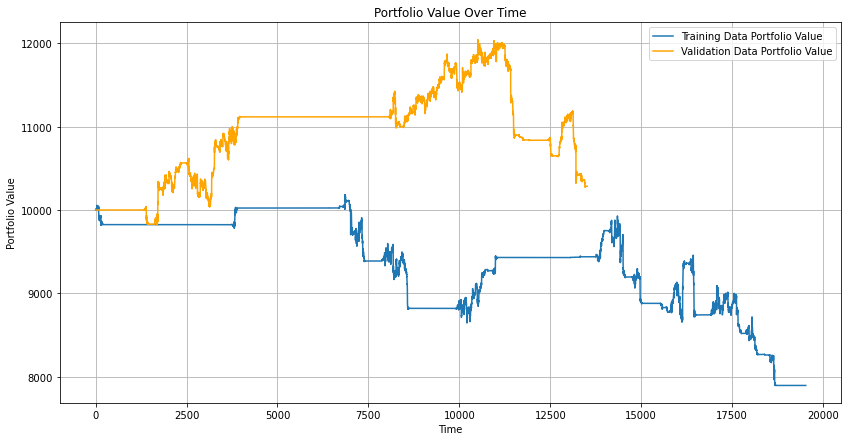

In [8]:
#8. Results & Conclusions
import matplotlib.pyplot as plt

# Plot portfolio values for training data
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label="Training Data Portfolio Value")
plt.plot(portfolio_values_val, label="Validation Data Portfolio Value", color='orange')
plt.title("Portfolio Value Over Time")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
